In [1]:
from typing import Optional
import datetime
import logging
import re
import os
import dask.dataframe
import dask.distributed
import numpy as np
import pandas as pd
import pyinterp.backends.xarray
import pyinterp.geodetic
import xarray as xr
import time
import intake
import cartopy
dask.config.set(temporary_directory='/home/jovyan')

## Local Dask cluster configuration

In [2]:
cluster = dask.distributed.LocalCluster(n_workers=4)
client = dask.distributed.Client(cluster)
client

<Client: 'tcp://127.0.0.1:34633' processes=4 threads=8, memory=32.00 GiB>

## Spatial coverage selection

In [3]:
def _select_area(ddf: dask.dataframe.DataFrame, box: pyinterp.geodetic.Box2D):
    """Applies geographic selection to a DataFrame of a partition"""
    return list(
        box.covered_by(ddf.longitude.values, ddf.latitude.values).astype(bool))


def select_area(ddf: dask.dataframe.DataFrame, box: pyinterp.geodetic.Box2D):
    """Applies geographic selection to a DataFrame"""
    return ddf.map_partitions(_select_area, box)

In [4]:
# Creation of the data selection box.
area = pyinterp.geodetic.Box2D(
    pyinterp.geodetic.Point2D(-57, 10),
    pyinterp.geodetic.Point2D(20, 60))
area

((-57, 10), (20, 60))

Column
    [0] Row
        [0] PNG(str)
        [1] Row
            [0] Column
                [0] Column(name='Select Data Source')
                    [0] Markdown(str, max_height=40)
                    [1] MultiSelect(min_width=200, options=OrderedDict([('gslh', ...]), size=9, value=[name: gslh
container: xar...], width_policy='min')
                [1] Row(name='Controls')
                    [0] Toggle(name='📊', width=50)
                    [1] Toggle(disabled=True, name='⚙', width=50)
            [1] Column(height=240, name='Description', scroll=True, sizing_mode='stretch_width', width_policy='max')
                [0] Markdown(str)
    [1] Column(name='Plot', width_policy='max')
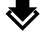

In [5]:
intake_cat = intake.open_catalog("/home/jovyan/eosc-pillar-dataspace/EOSCPillar4EarthScience/RO/intake/ocean.yaml")
intake_cat.gui

In [6]:
ddf = intake_cat.argo(year=[2010], month=range(1, 6)).to_dask()

# Subsetting a specific area.
df = ddf[select_area(ddf, area)].compute()

In [7]:
len(df)

5717

## Visualizing sea water temperature from Argo dataset

In [ ]:
# Visualization of the result
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
%matplotlib inline

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
sc = ax.scatter(
    df.longitude,
    df.latitude,
    1,
    c=[item[0] for item in df.temp],
    transform=ccrs.PlateCarree(),
    cmap='jet')
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
fig.colorbar(sc)

## Computing pressure anomalies from Argo dataset

In [ ]:
def pressure_anomalies(df):
    """Calculates pressure anomalies"""
    return df.pres - df.pres_adjusted

In [ ]:
# Here only columns containing the longitude and latitude of the floats are
# selected.
df = ddf[['longitude', 'latitude']].compute()
df['anomalies'] = ddf.map_partitions(
    pressure_anomalies, meta=(None, 'f8')).compute()

In [ ]:
# The average anomaly is calculated
df['mean_anomalies'] = df['anomalies'].map(
    lambda series: np.nan if np.all(np.isnan(series)) else np.nanmean(series))

In [ ]:
df

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
sc = ax.scatter(
    df.longitude,
    df.latitude,
    1,
    c=df.mean_anomalies,
    transform=ccrs.PlateCarree(),
    cmap='jet',
    vmin=-1,
    vmax=1)
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
fig.colorbar(sc)

## SLA interpolation on Argo float positions

In [ ]:
class GridSeries:
    """Handles a series of grids stored in zarr format. This series is a
    time series."""
    def __init__(self, ds):
        self.ds = ds
        self.series, self.dt = self._load_ts()

        
    @staticmethod
    def _is_sorted(array):
        indices = np.argsort(array)
        return np.all(indices == np.arange(len(indices)))

    def _load_ts(self):
        """Loading the time series into memory."""
        time = self.ds.time
        assert self._is_sorted(time)

        series = pd.Series(time)
        frequency = set(np.diff(series.values.astype("datetime64[s]")).astype("int64"))
        if len(frequency) != 1:
            raise RuntimeError(
                "Time series does not have a constant step between two "
                f"grids: {frequency} seconds")
        return series, datetime.timedelta(seconds=float(frequency.pop()))
    
    def load_dataset(self, varname, start, end):
        """Loading the time series into memory for the defined period.

        Args:
            varname (str): Name of the variable to be loaded into memory.
            start (datetime.datetime): Date of the first map to be loaded.
            end (datetime.datetime): Date of the last map to be loaded.

        Return:
            pyinterp.backends.xarray.Grid3D: The interpolator handling the
            interpolation of the grid series.
        """
        if start < self.series.min() or end > self.series.max():
            raise IndexError(
                f"period [{start}, {end}] out of range [{self.series.min()}, "
                f"{self.series.max()}]")
        first = start - self.dt
        last = end + self.dt

#         selected = self.series[(self.series >= first) & (self.series < last)]
        selected = self.series[(self.series >= start) & (self.series < end)]
        
        data_array = ds[varname].isel(time=selected.index)
        return pyinterp.backends.xarray.Grid3D(data_array)

In [ ]:
def interpolate(df, grid_series, varname):
    """Interpolate a variable 'varname' described by the time series
    'grid_series' for the locations provided in the DataFrame 'df'"""
    if not len(df):
        return np.array([])
    # The DataFrame must be ordered by the time axis
    df = df.set_index("datetime")
    # The time axis is divided into monthly periods
    period_start = df.groupby(df.index.to_period('M'))["sla"].count().index
    periods = []

    end = None
    
    # Calculates the period required to interpolate the data from the provided
    # time series
    for start, end in zip(period_start, period_start[1:]):
#         print(f"Calculating period : {start} -> {end}")
        start = start.to_timestamp()
        if start < grid_series.df.index[0]:
            start = grid_series.df.index[0]
        end = end.to_timestamp()
        periods.append((start, end))
    if end is None:
        end = period_start[0].to_timestamp()
#         print(f"End is none so it will be : {end}")
        
#     periods.append((end, df.index[-1] + datetime.timedelta(seconds=3600)))
    periods.append((end, df.index.max() + datetime.timedelta(seconds=3600)))

    # Finally, the data on the different periods identified are interpolated.
    result = []
    for start, end in periods:
        interpolator = grid_series.load_dataset(varname, start, end)
        mask = (df.index >= start) & (df.index < end)
        selected = df.loc[mask, ["longitude", "latitude"]]
        result.append(
            interpolator.trivariate(dict(
                longitude=selected["longitude"].values,
                latitude=selected["latitude"].values,
                time=selected.index.values),
                                    interpolator="inverse_distance_weighting",
                                    num_threads=1))
    
    return pd.Series(np.hstack(result), df.index)

# Loading SLA dataset from zarr store

In [ ]:
ds = intake_cat.gslh().to_dask()

lon_attrs = ds.longitude.attrs
ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180))#.sortby('time')
ds.longitude.attrs = lon_attrs


In [ ]:
# DELETE
ds = ds.drop("crs")
ds

In [ ]:
grid_series = GridSeries(ds)

In [ ]:
# Calculation of SLA
# sla = ddf.map_partitions(interpolate, grid_series, 'sla', meta=('result', np.float64)).compute(scheduler="single-threaded")
sla = ddf.map_partitions(interpolate, grid_series, 'sla', meta=('result', np.float64)).compute()

In [ ]:
# Generation of a DataFrame containing the float positions and the
# interpolated SLA.
df = ddf[["datetime", "longitude", "latitude"]].compute()
df = df.join(sla, on="datetime")

### Visualization of the result

In [ ]:
first = df.datetime.min()
last = df.datetime.max()
size = (df.datetime - first) / (last-first)

In [ ]:
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
sc = ax.scatter(
    df.longitude,
    df.latitude,
    s=size*100,
    c=df.result,
    transform=ccrs.PlateCarree(),
    cmap='jet')
ax.coastlines()
ax.set_title("Time series of SLA "
             "(larger points are closer to the last date)")
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
# ax.set_extent([80, 100, 13.5, 25], crs=ccrs.PlateCarree())
fig.colorbar(sc)
